# 推荐系统效果分析 (Recommendation Quality Analysis)

## 分析目标
本notebook聚焦于**人能理解的**分析指标，回答核心问题：**推荐得好不好？**

## 分析模块
1. **案例深度分析** - 随机抽取公司，展示完整推荐链条，人工判断质量
2. **推荐热度分析** - 哪些公司被推荐最多？头部抑制有效吗？
3. **多样性分析** - 推荐结果是否多样化？覆盖率如何？
4. **推荐网络可视化** - 公司间的推荐关系图
5. **分数分布与异常检测** - 发现可能的问题推荐
6. **头部抑制效果评估** - 评估抑制策略是否有效

---
## 0. 数据加载与基础设置

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from pathlib import Path
import random
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# 中文字体配置
# 说明：确保matplotlib能正确显示中文
# macOS可用字体：Hiragino Sans GB, Heiti TC, Songti SC, Arial Unicode MS
# ==========================================
plt.rcParams['font.sans-serif'] = ['Hiragino Sans GB', 'Heiti TC', 'Arial Unicode MS', 'Songti SC', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-whitegrid')

# 设置显示选项
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_rows', 100)

# 验证字体配置
import matplotlib.font_manager as fm
available_fonts = [f.name for f in fm.fontManager.ttflist]
configured_fonts = plt.rcParams['font.sans-serif']
print('字体配置检查:')
for font in configured_fonts[:3]:
    status = '[OK]' if font in available_fonts else '[缺失]'
    print(f'  {status} {font}')

字体配置检查:
  [OK] Arial
  [缺失] Liberation Sans
  [OK] DejaVu Sans


In [2]:
# ==========================================
# 加载所有数据源
# ==========================================

# 1. 加载推荐结果
# 说明：包含每个公司的多维度推荐列表
RECOMMENDATIONS_PATH = Path("output_production/recommendations.json")
with open(RECOMMENDATIONS_PATH, "r", encoding="utf-8") as f:
    recommendations = json.load(f)
print(f"[OK] 加载推荐数据: {len(recommendations)} 个公司")

# 2. 加载公司原始信息
# 说明：公司名称、描述等原始数据，用于展示案例
COMPANIES_PATH = Path("data/aihirebox_company_list.csv")
companies_df = pd.read_csv(COMPANIES_PATH)
company_info = companies_df.set_index('company_id').to_dict('index')
print(f"[OK] 加载公司信息: {len(company_info)} 家公司")

# 3. 加载公司标签
# 说明：LLM生成的MECE标签，用于理解推荐依据
TAGS_PATH = Path("output_production/company_tags.json")
with open(TAGS_PATH, "r", encoding="utf-8") as f:
    company_tags = json.load(f)
tags_dict = {t['company_id']: t for t in company_tags}
print(f"[OK] 加载公司标签: {len(tags_dict)} 家公司")

[OK] 加载推荐数据: 132 个公司
[OK] 加载公司信息: 132 家公司
[OK] 加载公司标签: 132 家公司


In [3]:
# ==========================================
# 展平推荐数据为DataFrame
# 说明：将嵌套的JSON结构转为扁平表格，便于分析
# ==========================================

records = []
for rec in recommendations:
    query_id = rec["query_company_id"]
    query_name = rec["query_company_name"]
    
    for group in rec["recommendation_groups"]:
        dim_key = group["dimension_key"]
        dim_label = group["dimension_label_zh"]
        shared_tags = group.get("shared_tags", [])
        
        for company in group["companies"]:
            records.append({
                "query_id": query_id,
                "query_name": query_name,
                "dimension_key": dim_key,
                "dimension_label": dim_label,
                "recommended_id": company["company_id"],
                "recommended_name": company["company_name"],
                "similarity_score": company["similarity_score"],  # 最终分数（含头部抑制）
                "raw_score": company["raw_score"],  # 原始标签分数
                "embedding_score": company.get("embedding_score"),  # 语义相似度分数
                "head_penalty_applied": company["head_penalty_applied"],  # 是否应用了头部抑制
                "num_shared_tags": len(shared_tags),
                "shared_tags": "|".join(shared_tags),
            })

df = pd.DataFrame(records)

print("\n" + "="*60)
print("[图] 数据概览")
print("="*60)
print(f"总推荐记录数: {len(df):,}")
print(f"查询公司数 (有推荐结果的公司): {df['query_id'].nunique()}")
print(f"被推荐公司数 (出现在推荐列表中的公司): {df['recommended_id'].nunique()}")
print(f"推荐维度类型数: {df['dimension_key'].nunique()}")
print(f"平均每个公司的推荐维度数: {len(df) / df['query_id'].nunique():.1f}")


[图] 数据概览
总推荐记录数: 1,880
查询公司数 (有推荐结果的公司): 129
被推荐公司数 (出现在推荐列表中的公司): 85
推荐维度类型数: 14
平均每个公司的推荐维度数: 14.6


---
## 1. 案例深度分析 (Case Study)

**目的**: 随机抽取几个公司，完整展示其推荐结果，让人直接判断推荐质量。

这是最核心的分析模块——通过具体案例来理解推荐效果。

In [4]:
def show_company_case(company_id: str):
    """
    展示单个公司的完整推荐案例
    
    展示内容：
    1. 查询公司的基本信息和标签
    2. 每个推荐维度的推荐公司
    3. 被推荐公司的信息对比
    """
    # 获取该公司的推荐结果
    rec = next((r for r in recommendations if r['query_company_id'] == company_id), None)
    if not rec:
        print(f"[X] 未找到公司 {company_id} 的推荐数据")
        return
    
    # 获取公司信息
    info = company_info.get(company_id, {})
    tags = tags_dict.get(company_id, {})
    
    print("\n" + "="*80)
    print(f"[查] 案例分析: {rec['query_company_name']} ({company_id})")
    print("="*80)
    
    # 1. 展示公司基本信息
    print("\n【公司简介】")
    details = info.get('company_details', '无描述')
    print(f"  {details[:200]}..." if len(details) > 200 else f"  {details}")
    
    # 2. 展示公司标签
    print("\n【公司标签】(LLM提取的MECE标签)")
    if tags:
        print(f"  行业领域: {', '.join(tags.get('industry', []))}")
        print(f"  商业模式: {', '.join(tags.get('business_model', []))}")
        print(f"  目标市场: {', '.join(tags.get('target_market', []))}")
        print(f"  发展阶段: {tags.get('company_stage', '未知')}")
        print(f"  技术方向: {', '.join(tags.get('tech_focus', []))}")
        print(f"  团队背景: {', '.join(tags.get('team_background', []))}")
    
    # 3. 展示各维度推荐
    print("\n" + "-"*80)
    print(f"[表] 推荐结果 (共 {len(rec['recommendation_groups'])} 个维度)")
    print("-"*80)
    
    for i, group in enumerate(rec['recommendation_groups'], 1):
        print(f"\n【维度{i}】{group['dimension_label_zh']}")
        print(f"  推荐依据: {group['reason']}")
        print(f"  共同标签: {', '.join(group['shared_tags'])}")
        print("  推荐公司:")
        
        for c in group['companies']:
            penalty = "⬇降权" if c['head_penalty_applied'] else ""
            emb = f"语义={c['embedding_score']:.2f}" if c.get('embedding_score') else ""
            
            # 获取被推荐公司的简介
            rec_info = company_info.get(c['company_id'], {})
            rec_details = rec_info.get('company_details', '')
            short_desc = rec_details[:80] + "..." if len(rec_details) > 80 else rec_details
            
            print(f"    • {c['company_name']} (分数={c['similarity_score']:.2f} {penalty} {emb})")
            print(f"      └─ {short_desc}")
    
    print("\n" + "="*80)
    print("[提示] 请思考: 上述推荐是否合理？被推荐的公司和查询公司是否真的相似？")
    print("="*80)

In [5]:
# ==========================================
# 随机抽取3个公司进行案例分析
# 说明：人工检查推荐质量的最直接方式
# ==========================================

random.seed(42)  # 固定随机种子，便于复现
sample_ids = random.sample([r['query_company_id'] for r in recommendations], 3)

for cid in sample_ids:
    show_company_case(cid)


[查] 案例分析: GE医疗 (cid_123)

【公司简介】
  GE 医疗致力于成为全球领先的医疗科技、药物诊断和数字化解决方案的创新者，通过提供整合 解决方案、服务、数据分析，使医院运营更加高效、临床医生诊断更加有效、治疗方法更加精准、 患者更加健康和幸福。在为患者和医疗机构提供服务的 100 多年中，GE 医疗一直在推进个性化、互 联互通和更富同理心的医疗关爱，同时简化患者诊疗全流程。GE 医疗的医学影像、超声、生命关爱 和药物诊断业务覆盖从诊断治疗到监护...

【公司标签】(LLM提取的MECE标签)
  行业领域: healthtech
  商业模式: b2b, hardware, platform
  目标市场: global, china_domestic
  发展阶段: public
  技术方向: computer_vision, data_infra
  团队背景: industry_expert, international, top_university

--------------------------------------------------------------------------------
[表] 推荐结果 (共 2 个维度)
--------------------------------------------------------------------------------

【维度1】同为全球化公司
  推荐依据: 这些公司与GE医疗在同为全球化公司方面相似
  共同标签: global, china_domestic
  推荐公司:
    • 元气森林 (分数=0.83 ⬇降权 语义=0.68)
      └─ 元气森林成立于2016年，以“一群有爱的人在一个有爱的组织创造有爱的产品”为使命、“整合全球资源为全球用户创造有爱的好产品”为愿景，致力于为美好生活创造健康好产...
    • 海豚智声 (分数=0.83 ⬇降权 语义=0.75)
      └─ 我们是一家深耕AI+医疗领域的创新型企业，海宁海豚之声医疗科技有限公司专注于研发和推广智能医用超声技术研发，致力于通过AI技术和超声技术的结合，为医疗机构提供安...
    • YCC Films (分数=0.82 ⬇降权 语义=0

In [6]:
# ==========================================
# 交互式案例查看
# 说明：输入任意公司ID查看其推荐情况
# ==========================================

# 取消注释下面的行来查看特定公司
# show_company_case("cid_0")  # Apex Context
# show_company_case("cid_100")  # MiniMax
show_company_case("cid_109")  # DeepSeek


[查] 案例分析: DeepSeek (cid_109)

【公司简介】
  我们相信，AGI 是数据x算法x算力的完美实践，科研+工程+组织的优雅艺术。 我们正在寻找并长期培养优秀的数据研发人才，与我们一起进行高水平的科学研究和工程实践。如果你对人工智能有浓厚的兴趣，如果你想在一个充满挑战和机遇的初创环境中展现你的才华，如果你想参与构建下一代通用人工智能（AGI），那么请不要犹豫，加入 DeepSeek，与我们共同在 AGI 征程上“深度求索”吧！

【公司标签】(LLM提取的MECE标签)
  行业领域: ai_llm
  商业模式: b2b, saas
  目标市场: china_domestic
  发展阶段: early
  技术方向: llm_foundation, aigc
  团队背景: unknown

--------------------------------------------------------------------------------
[表] 推荐结果 (共 5 个维度)
--------------------------------------------------------------------------------

【维度1】同为国内市场公司
  推荐依据: 这些公司与DeepSeek在同为国内市场公司方面相似
  共同标签: china_domestic
  推荐公司:
    • 月之暗面(Kimi) (分数=0.88 ⬇降权 语义=0.78)
      └─ - Kimi 是一家专注于通用人工智能（Artificial General Intelligence，AGI）领域的公司，致力于寻求将能源转化为智能的最优解，...
    • 阶跃星辰 (分数=0.87 ⬇降权 语义=0.77)
      └─ 阶跃星辰于2023年4月成立，以“智能阶跃，十倍每一个人的可能”为使命，是行业领先的通用大模型创业公司，坚定探索实现通用人工智能（AGI）的道路，已对外发布St...
    • 清程极智 (分数=0.87 ⬇降权 语义=0.79)
      └─ 清程极智科技有限公司是清华系 AI Infra 明星创新企业，致力于通过高效、易用的智能算力系统软件提升算力使用效率，降低大模型落地成本，为国

---
## 2. 推荐热度分析 (Popularity Analysis)

**目的**: 看哪些公司被推荐得最多，判断头部抑制是否有效。

如果某些公司总是被推荐（霸榜），说明头部抑制可能不够强。

In [7]:
# ==========================================
# 被推荐次数排行榜 Top 20
# 说明：看哪些公司被推荐得最多，是否存在"霸榜"现象
# ==========================================

# 统计每个公司被推荐的次数
recommended_counts = df['recommended_id'].value_counts().reset_index()
recommended_counts.columns = ['company_id', 'times_recommended']

# 添加公司名称
recommended_counts['company_name'] = recommended_counts['company_id'].apply(
    lambda x: company_info.get(x, {}).get('company_name', x)
)

# 添加公司阶段（用于判断是否是头部公司）
recommended_counts['company_stage'] = recommended_counts['company_id'].apply(
    lambda x: tags_dict.get(x, {}).get('company_stage', '未知')
)

print("\n" + "="*60)
print("[榜] 被推荐次数排行榜 Top 20")
print("说明: 被推荐次数越多，说明这个公司在推荐结果中出现越频繁")
print("="*60)
print()

top20 = recommended_counts.head(20)
for i, row in top20.iterrows():
    stage_emoji = "[大]" if row['company_stage'] in ['public', 'bigtech_subsidiary', 'profitable', 'pre_ipo'] else "[小]"
    print(f"{i+1:2d}. {row['company_name'][:20]:<20} | {row['times_recommended']:3d}次 | {stage_emoji} {row['company_stage']}")


[榜] 被推荐次数排行榜 Top 20
说明: 被推荐次数越多，说明这个公司在推荐结果中出现越频繁

 1. K2 Lab               |  86次 | [小] seed
 2. DeepSeek             |  69次 | [小] early
 3. OpenCreator          |  68次 | [小] early
 4. NoDesk AI            |  65次 | [小] seed
 5. 浮点奇迹                 |  64次 | [小] early
 6. 阶跃星辰                 |  59次 | [小] early
 7. 闻声知意                 |  50次 | [小] early
 8. JOJOMath（成都书声科技有限公司） |  50次 | [小] growth
 9. 智启心源/Refly. ai       |  46次 | [小] early
10. 倍泽科技                 |  44次 | [小] early
11. 上海人工智能实验室            |  44次 | [小] unknown
12. 高榕创投                 |  44次 | [小] growth
13. 月之暗面(Kimi)           |  42次 | [小] early
14. Second Me            |  42次 | [小] early
15. Ainia                |  37次 | [小] early
16. Holovita AI          |  36次 | [小] growth
17. 元气森林                 |  36次 | [小] growth
18. 虚空博弈                 |  35次 | [小] early
19. Guru                 |  35次 | [小] growth
20. 百川智能                 |  34次 | [小] early


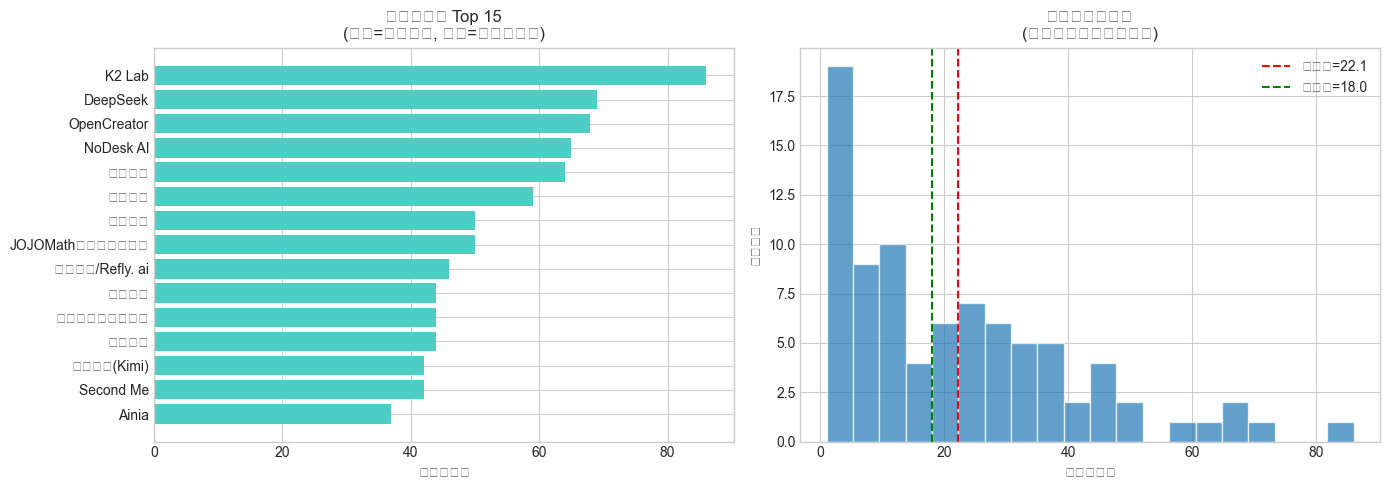


[提示] 解读: 如果大量推荐位被少数公司占据，说明推荐多样性不足


In [8]:
# ==========================================
# 可视化：被推荐次数分布
# 说明：理想情况下应该呈长尾分布，而非极度集中
# ==========================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：被推荐次数Top 15柱状图
ax1 = axes[0]
top15 = recommended_counts.head(15)
colors = ['#ff6b6b' if s in ['public', 'bigtech_subsidiary', 'profitable', 'pre_ipo'] else '#4ecdc4' 
          for s in top15['company_stage']]
bars = ax1.barh(range(len(top15)), top15['times_recommended'], color=colors)
ax1.set_yticks(range(len(top15)))
ax1.set_yticklabels([n[:15] for n in top15['company_name']])
ax1.invert_yaxis()
ax1.set_xlabel('被推荐次数')
ax1.set_title('被推荐次数 Top 15\n(红色=头部公司, 青色=非头部公司)')

# 右图：被推荐次数分布直方图
ax2 = axes[1]
ax2.hist(recommended_counts['times_recommended'], bins=20, edgecolor='white', alpha=0.7)
ax2.axvline(recommended_counts['times_recommended'].mean(), color='red', linestyle='--', label=f'平均值={recommended_counts["times_recommended"].mean():.1f}')
ax2.axvline(recommended_counts['times_recommended'].median(), color='green', linestyle='--', label=f'中位数={recommended_counts["times_recommended"].median():.1f}')
ax2.set_xlabel('被推荐次数')
ax2.set_ylabel('公司数量')
ax2.set_title('被推荐次数分布\n(理想情况应呈长尾分布)')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n[提示] 解读: 如果大量推荐位被少数公司占据，说明推荐多样性不足")

In [10]:
# ==========================================
# 冷门公司警报：几乎不被推荐的公司
# 说明：这些公司可能是"孤立节点"，值得检查原因
# ==========================================

# 找出从未被推荐的公司
all_company_ids = set(company_info.keys())
recommended_company_ids = set(df['recommended_id'].unique())
never_recommended = all_company_ids - recommended_company_ids

print("\n" + "="*60)
print("[!] 冷门公司警报：从未被推荐的公司")
print("说明: 这些公司可能标签独特或描述特殊，是潜在的推荐死角")
print("="*60)
print(f"\n共 {len(never_recommended)} 家公司从未出现在任何推荐列表中:\n")

for cid in list(never_recommended)[:]:  # 只显示前10个
    info = company_info.get(cid, {})
    tags = tags_dict.get(cid, {})
    print(f"• {info.get('company_name', cid)}")
    print(f"  行业: {', '.join(tags.get('industry', ['未知']))}")
    print(f"  阶段: {tags.get('company_stage', '未知')}")
    print()


[!] 冷门公司警报：从未被推荐的公司
说明: 这些公司可能标签独特或描述特殊，是潜在的推荐死角

共 47 家公司从未出现在任何推荐列表中:

• bilibili
  行业: content_media, gaming, social, ecommerce
  阶段: public

• GE医疗
  行业: healthtech
  阶段: public

• 华为 - ICT基础设施业务
  行业: cloud_infra, semiconductor, enterprise_saas
  阶段: bigtech_subsidiary

• 飞书
  行业: enterprise_saas, ai_llm
  阶段: bigtech_subsidiary

• 高德
  行业: enterprise_saas, automotive
  阶段: bigtech_subsidiary

• 西门子医疗
  行业: healthtech
  阶段: public

• 金山办公 - WPS
  行业: enterprise_saas, content_media
  阶段: public

• 挚文集团
  行业: social, content_media
  阶段: public

• 美团
  行业: ecommerce, enterprise_saas
  阶段: public

• 饿了么
  行业: ecommerce, enterprise_saas
  阶段: bigtech_subsidiary

• 蚂蚁数字科技
  行业: fintech, enterprise_saas, cloud_infra, other
  阶段: bigtech_subsidiary

• 英特尔
  行业: semiconductor, consumer_hw, cloud_infra
  阶段: public

• 蚂蚁集团
  行业: fintech, enterprise_saas, cloud_infra
  阶段: pre_ipo

• Shopee
  行业: ecommerce
  阶段: public

• 嘉实基金
  行业: investment
  阶段: profitable

• 晶泰科技XtalPi
  行业: biotech, h

In [11]:
# ==========================================
# 推荐/被推荐比分析
# 说明：某公司推荐别人的次数 vs 被推荐的次数
#       比值高=经常推荐别人但不被推荐（可能是独特公司）
#       比值低=经常被推荐但不推荐别人（可能是热门公司）
# ==========================================

# 统计每个公司作为查询公司推荐了多少次
query_counts = df.groupby('query_id').size().reset_index(name='times_as_query')

# 合并推荐和被推荐数据
ratio_df = pd.merge(
    query_counts.rename(columns={'query_id': 'company_id'}),
    recommended_counts[['company_id', 'times_recommended']],
    on='company_id',
    how='outer'
).fillna(0)

ratio_df['ratio'] = (ratio_df['times_as_query'] + 1) / (ratio_df['times_recommended'] + 1)
ratio_df['company_name'] = ratio_df['company_id'].apply(
    lambda x: company_info.get(x, {}).get('company_name', x)
)

print("\n" + "="*60)
print("[图] 推荐/被推荐比分析")
print("="*60)

print("\n* 高比值公司 (经常推荐别人，但很少被推荐)：")
high_ratio = ratio_df.nlargest(5, 'ratio')
for _, row in high_ratio.iterrows():
    print(f"  {row['company_name'][:25]:<25} 推荐{int(row['times_as_query']):2d}次 | 被推荐{int(row['times_recommended']):2d}次")

print("\n* 低比值公司 (经常被推荐，但推荐别人少)：")
low_ratio = ratio_df[ratio_df['times_recommended'] > 0].nsmallest(5, 'ratio')
for _, row in low_ratio.iterrows():
    print(f"  {row['company_name'][:25]:<25} 推荐{int(row['times_as_query']):2d}次 | 被推荐{int(row['times_recommended']):2d}次")


[图] 推荐/被推荐比分析

* 高比值公司 (经常推荐别人，但很少被推荐)：
  昆仑天工                      推荐25次 | 被推荐 0次
  阿里云                       推荐25次 | 被推荐 0次
  商汤科技                      推荐25次 | 被推荐 0次
  第四范式                      推荐20次 | 被推荐 0次
  字节 火山引擎                   推荐15次 | 被推荐 0次

* 低比值公司 (经常被推荐，但推荐别人少)：
  高榕创投                      推荐10次 | 被推荐44次
  K2 Lab                    推荐24次 | 被推荐86次
  NoDesk AI                 推荐18次 | 被推荐65次
  OpenCreator               推荐20次 | 被推荐68次
  虚空博弈                      推荐10次 | 被推荐35次


---
## 3. 多样性分析 (Diversity Analysis)

**目的**: 看推荐结果是否多样化，还是总推荐那几家公司。

In [12]:
# ==========================================
# 覆盖率分析
# 说明：有多少公司能进入推荐列表？覆盖率越高，推荐越多样化
# ==========================================

total_companies = len(company_info)
unique_recommended = df['recommended_id'].nunique()
coverage_rate = unique_recommended / total_companies * 100

print("\n" + "="*60)
print("[图] 推荐覆盖率分析")
print("="*60)
print(f"\n总公司数: {total_companies}")
print(f"被推荐过的公司数: {unique_recommended}")
print(f"覆盖率: {coverage_rate:.1f}%")
print(f"\n[提示] 解读: 覆盖率{coverage_rate:.1f}%意味着有{total_companies - unique_recommended}家公司从未被推荐")


[图] 推荐覆盖率分析

总公司数: 132
被推荐过的公司数: 85
覆盖率: 64.4%

[提示] 解读: 覆盖率64.4%意味着有47家公司从未被推荐


In [13]:
# ==========================================
# 集中度分析
# 说明：前10%的公司占据了多少推荐位？比例越高，越集中
# ==========================================

# 计算累计推荐占比
sorted_counts = recommended_counts.sort_values('times_recommended', ascending=False)
sorted_counts['cumulative_pct'] = sorted_counts['times_recommended'].cumsum() / sorted_counts['times_recommended'].sum() * 100

# Top 10% 公司占比
top_10_pct_companies = int(len(sorted_counts) * 0.1)
top_10_pct_share = sorted_counts.head(top_10_pct_companies)['times_recommended'].sum() / sorted_counts['times_recommended'].sum() * 100

# Top 20% 公司占比
top_20_pct_companies = int(len(sorted_counts) * 0.2)
top_20_pct_share = sorted_counts.head(top_20_pct_companies)['times_recommended'].sum() / sorted_counts['times_recommended'].sum() * 100

print("\n" + "="*60)
print("[图] 推荐集中度分析")
print("说明: 如果少数公司占据大量推荐位，说明推荐过于集中")
print("="*60)
print(f"\nTop 10% 的公司 ({top_10_pct_companies}家) 占据了 {top_10_pct_share:.1f}% 的推荐位")
print(f"Top 20% 的公司 ({top_20_pct_companies}家) 占据了 {top_20_pct_share:.1f}% 的推荐位")

if top_10_pct_share > 50:
    print("\n[!] 警告: Top 10%公司占比超过50%，推荐过于集中！")
else:
    print("\n[OK] 推荐集中度在合理范围内")


[图] 推荐集中度分析
说明: 如果少数公司占据大量推荐位，说明推荐过于集中

Top 10% 的公司 (8家) 占据了 27.2% 的推荐位
Top 20% 的公司 (17家) 占据了 46.9% 的推荐位

[OK] 推荐集中度在合理范围内


In [14]:
# ==========================================
# 维度使用频率分析
# 说明：各推荐维度被使用的频率是否均衡
# ==========================================

dimension_counts = df.groupby(['dimension_key', 'dimension_label']).size().reset_index(name='count')
dimension_counts = dimension_counts.sort_values('count', ascending=False)

print("\n" + "="*60)
print("[标签] 推荐维度使用频率")
print("说明: 各维度被使用的次数，反映推荐的多样性")
print("="*60)
print()

for _, row in dimension_counts.iterrows():
    bar_len = int(row['count'] / dimension_counts['count'].max() * 30)
    bar = "█" * bar_len
    print(f"{row['dimension_label']:<15} | {bar} {row['count']}")


[标签] 推荐维度使用频率
说明: 各维度被使用的次数，反映推荐的多样性

同为国内市场公司        | ██████████████████████████████ 570
同为全球化公司         | █████████████████████ 405
同为成长期公司         | ██████████ 205
同为早期创业公司        | █████████ 185
同为B2B企业服务       | ███████ 135
同为大模型技术         | █████ 95
业务描述相似          | ████ 85
同为AIGC内容生成      | ███ 60
同为大厂背景团队        | ██ 45
同为顶尖高校背景        | ██ 40
同为种子期公司         | █ 20
同为C端消费产品        |  15
同为平台模式          |  15
同为SaaS订阅模式      |  5


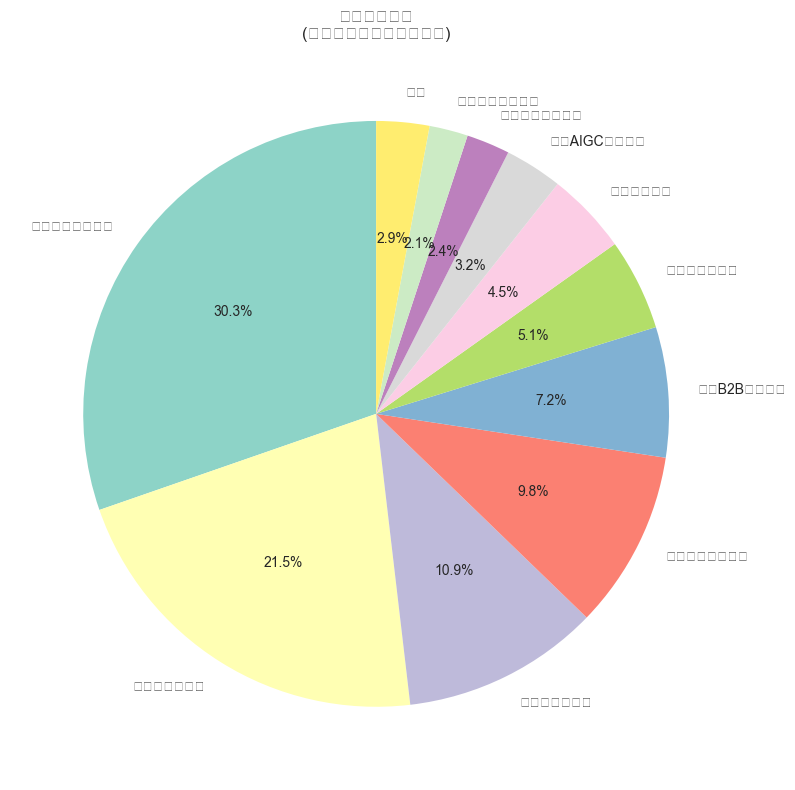

In [15]:
# ==========================================
# 可视化：维度分布饼图
# ==========================================

fig, ax = plt.subplots(figsize=(10, 8))

# 只显示前10个维度
top_dims = dimension_counts.head(10)
other_count = dimension_counts.iloc[10:]['count'].sum() if len(dimension_counts) > 10 else 0

labels = top_dims['dimension_label'].tolist()
sizes = top_dims['count'].tolist()
if other_count > 0:
    labels.append('其他')
    sizes.append(other_count)

colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax.set_title('推荐维度分布\n(各维度在总推荐中的占比)')

plt.tight_layout()
plt.show()

---
## 4. 推荐网络可视化 (Network Visualization)

**目的**: 用图的方式展示公司间的推荐关系，直观理解推荐网络结构。

In [16]:
# ==========================================
# 互惠推荐分析
# 说明：如果A推荐B，B也推荐A，这是"互惠推荐"
#       互惠率高说明推荐关系是双向的、对称的
# ==========================================

# 构建推荐边集合
edges = set()
for _, row in df.iterrows():
    edges.add((row['query_id'], row['recommended_id']))

# 统计互惠边
reciprocal_edges = set()
for a, b in edges:
    if (b, a) in edges:
        reciprocal_edges.add(tuple(sorted([a, b])))

reciprocal_rate = len(reciprocal_edges) * 2 / len(edges) * 100 if edges else 0

print("\n" + "="*60)
print("[循环] 互惠推荐分析")
print("说明: 如果A推荐B且B也推荐A，这是互惠推荐")
print("="*60)
print(f"\n总推荐边数: {len(edges)}")
print(f"互惠推荐对数: {len(reciprocal_edges)}")
print(f"互惠率: {reciprocal_rate:.1f}%")

print("\n* 互惠推荐示例 (前10对)：")
for i, (a, b) in enumerate(list(reciprocal_edges)[:10]):
    name_a = company_info.get(a, {}).get('company_name', a)
    name_b = company_info.get(b, {}).get('company_name', b)
    print(f"  {name_a[:20]} ↔ {name_b[:20]}")


[循环] 互惠推荐分析
说明: 如果A推荐B且B也推荐A，这是互惠推荐

总推荐边数: 1880
互惠推荐对数: 355
互惠率: 37.8%

* 互惠推荐示例 (前10对)：
  百川智能 ↔ Skylarq.ai
  PYRA ↔ 闻声知意
  元萝卜 ↔ 智元机器人
  VAST ↔ 元象科技
  Holovita AI ↔ Pollo.ai
  RockFlow ↔ Timetell.ai
  智启心源/Refly. ai ↔ 月之暗面(Kimi)
  信飞科技 ↔ 天创信用服务有限公司
  上海人工智能实验室 ↔ NoDesk AI
  Indievolve ↔ 深言科技


In [17]:
# ==========================================
# 简化的推荐网络可视化（使用matplotlib）
# 说明：展示公司间的推荐关系
# ==========================================

try:
    import networkx as nx
    
    # 构建图
    G = nx.DiGraph()
    
    # 只使用推荐次数最多的公司（避免图太复杂）
    top_companies = set(recommended_counts.head(30)['company_id'])
    
    # 添加边（只包含top公司）
    for _, row in df.iterrows():
        if row['query_id'] in top_companies and row['recommended_id'] in top_companies:
            G.add_edge(row['query_id'], row['recommended_id'])
    
    # 绘图
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # 布局
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # 节点大小根据入度
    in_degrees = dict(G.in_degree())
    node_sizes = [300 + in_degrees.get(n, 0) * 100 for n in G.nodes()]
    
    # 节点颜色根据公司阶段
    node_colors = []
    for n in G.nodes():
        stage = tags_dict.get(n, {}).get('company_stage', 'unknown')
        if stage in ['public', 'bigtech_subsidiary', 'profitable', 'pre_ipo']:
            node_colors.append('#ff6b6b')
        else:
            node_colors.append('#4ecdc4')
    
    # 绘制
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.2, arrows=True, arrowsize=10, ax=ax)
    
    # 标签
    labels = {n: company_info.get(n, {}).get('company_name', n)[:10] for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax)
    
    ax.set_title('推荐网络图 (Top 30 被推荐公司)\n红色=头部公司, 青色=非头部公司, 节点大小=被推荐次数')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("[!] 需要安装 networkx 库来绘制网络图")
    print("运行: pip install networkx")

[!] 需要安装 networkx 库来绘制网络图
运行: pip install networkx


---
## 5. 分数分布与异常检测 (Score Analysis)

**目的**: 发现可能的问题推荐，检查分数分布是否合理。

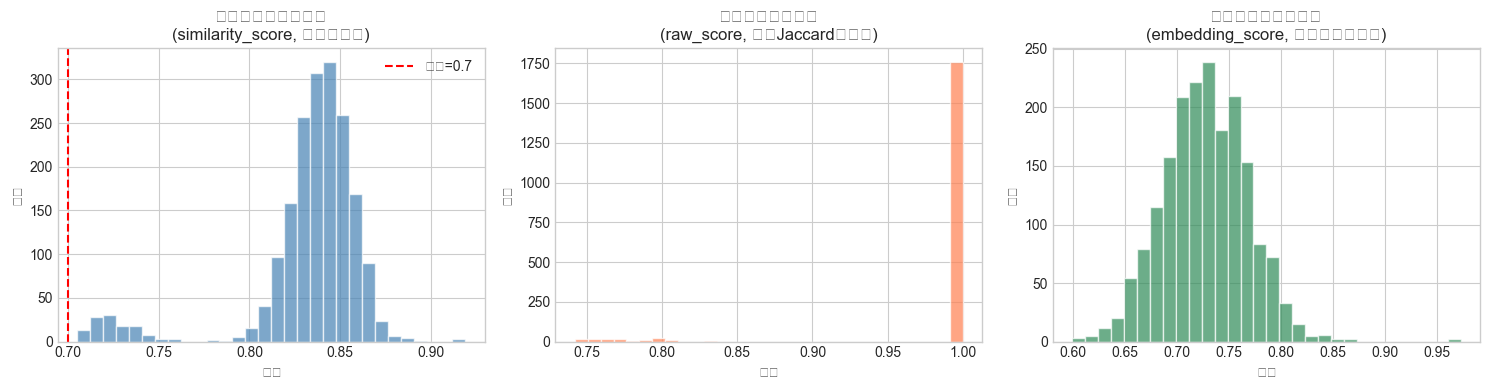


[图] 分数统计摘要：
  最终分数: 均值=0.833, 中位数=0.839, 标准差=0.032
  原始分数: 均值=0.986, 中位数=1.000, 标准差=0.055
  语义分数: 均值=0.727, 中位数=0.726, 标准差=0.041


In [18]:
# ==========================================
# 分数分布可视化
# 说明：三个核心分数的分布情况
#   - similarity_score: 最终分数（含头部抑制）
#   - raw_score: 原始标签相似度
#   - embedding_score: 语义向量相似度
# ==========================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 最终分数分布
ax1 = axes[0]
ax1.hist(df['similarity_score'], bins=30, edgecolor='white', alpha=0.7, color='steelblue')
ax1.axvline(0.7, color='red', linestyle='--', label='阈值=0.7')
ax1.set_xlabel('分数')
ax1.set_ylabel('频次')
ax1.set_title('最终相似度分数分布\n(similarity_score, 含头部抑制)')
ax1.legend()

# 原始标签分数分布
ax2 = axes[1]
ax2.hist(df['raw_score'], bins=30, edgecolor='white', alpha=0.7, color='coral')
ax2.set_xlabel('分数')
ax2.set_ylabel('频次')
ax2.set_title('原始标签分数分布\n(raw_score, 标签Jaccard相似度)')

# 语义分数分布
ax3 = axes[2]
emb_scores = df['embedding_score'].dropna()
ax3.hist(emb_scores, bins=30, edgecolor='white', alpha=0.7, color='seagreen')
ax3.set_xlabel('分数')
ax3.set_ylabel('频次')
ax3.set_title('语义相似度分数分布\n(embedding_score, 向量余弦相似度)')

plt.tight_layout()
plt.show()

print("\n[图] 分数统计摘要：")
print(f"  最终分数: 均值={df['similarity_score'].mean():.3f}, 中位数={df['similarity_score'].median():.3f}, 标准差={df['similarity_score'].std():.3f}")
print(f"  原始分数: 均值={df['raw_score'].mean():.3f}, 中位数={df['raw_score'].median():.3f}, 标准差={df['raw_score'].std():.3f}")
print(f"  语义分数: 均值={emb_scores.mean():.3f}, 中位数={emb_scores.median():.3f}, 标准差={emb_scores.std():.3f}")

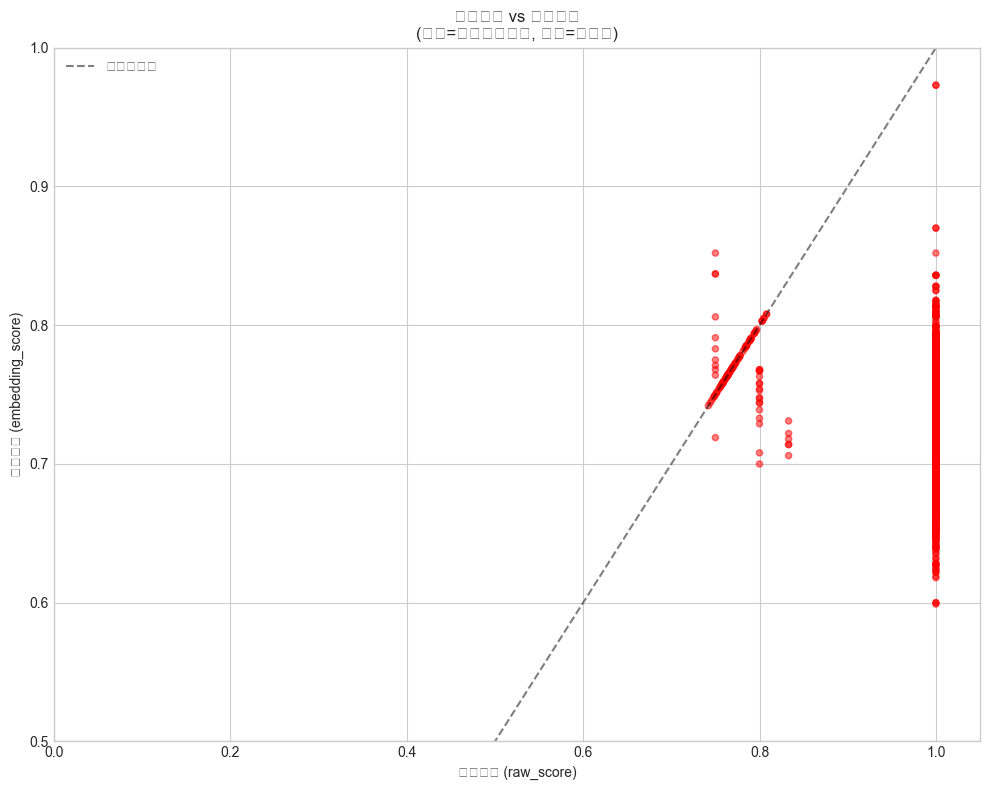


[!] 标签-语义差异最大的推荐 (可能需要检查)
说明: 标签匹配但语义不相似，或反之

* 标签高但语义低 (标签匹配但业务可能不相似):
  京东集团 → YCC Films | 标签=1.00, 语义=0.60, 差=0.40
  Advance Intelli → 深渡资本/Profound C | 标签=1.00, 语义=0.60, 差=0.40
  广联达科技有限公司 → YCC Films | 标签=1.00, 语义=0.60, 差=0.40
  广联达科技有限公司 → VIVA | 标签=1.00, 语义=0.62, 差=0.38
  Advance Intelli → JOJOMath（成都书声科技 | 标签=1.00, 语义=0.62, 差=0.38


In [19]:
# ==========================================
# Tag vs Embedding 一致性分析
# 说明：如果标签分数和语义分数差异很大，可能是问题推荐
#       - 标签高、语义低：标签匹配但业务不相似
#       - 标签低、语义高：业务相似但标签不匹配（可能标签有问题）
# ==========================================

# 计算差异
df_with_emb = df[df['embedding_score'].notna()].copy()
df_with_emb['score_diff'] = df_with_emb['raw_score'] - df_with_emb['embedding_score']

fig, ax = plt.subplots(figsize=(10, 8))

# 散点图：raw_score vs embedding_score
scatter = ax.scatter(
    df_with_emb['raw_score'],
    df_with_emb['embedding_score'],
    c=df_with_emb['head_penalty_applied'].map({True: 'red', False: 'blue'}),
    alpha=0.5,
    s=20
)

# 对角线（完美一致）
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='完美一致线')

ax.set_xlabel('标签分数 (raw_score)')
ax.set_ylabel('语义分数 (embedding_score)')
ax.set_title('标签分数 vs 语义分数\n(红色=应用头部抑制, 蓝色=未抑制)')
ax.legend()
ax.set_xlim(0, 1.05)
ax.set_ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

# 找出差异最大的案例
print("\n" + "="*60)
print("[!] 标签-语义差异最大的推荐 (可能需要检查)")
print("说明: 标签匹配但语义不相似，或反之")
print("="*60)

extreme_cases = df_with_emb.nlargest(5, 'score_diff')
print("\n* 标签高但语义低 (标签匹配但业务可能不相似):")
for _, row in extreme_cases.iterrows():
    print(f"  {row['query_name'][:15]} → {row['recommended_name'][:15]} | 标签={row['raw_score']:.2f}, 语义={row['embedding_score']:.2f}, 差={row['score_diff']:.2f}")

In [20]:
# ==========================================
# 边缘分数案例（接近阈值0.7的推荐）
# 说明：这些推荐质量可能较低，值得人工检查
# ==========================================

# 找出分数在0.7-0.75之间的推荐
edge_cases = df[(df['similarity_score'] >= 0.7) & (df['similarity_score'] <= 0.75)].copy()

print("\n" + "="*60)
print("[!] 边缘分数推荐 (0.70-0.75, 接近阈值)")
print("说明: 这些推荐刚好过阈值，质量可能较低")
print("="*60)
print(f"\n共有 {len(edge_cases)} 条边缘推荐，占总推荐的 {len(edge_cases)/len(df)*100:.1f}%")

print("\n* 随机抽取5条边缘推荐：")
sample_edge = edge_cases.sample(min(5, len(edge_cases)), random_state=42)
for _, row in sample_edge.iterrows():
    print(f"  [{row['dimension_label']}] {row['query_name'][:15]} → {row['recommended_name'][:15]} (分数={row['similarity_score']:.3f})")


[!] 边缘分数推荐 (0.70-0.75, 接近阈值)
说明: 这些推荐刚好过阈值，质量可能较低

共有 116 条边缘推荐，占总推荐的 6.2%

* 随机抽取5条边缘推荐：
  [业务描述相似] Alva → Ainia (分数=0.715)
  [业务描述相似] 寒武纪 → Indievolve (分数=0.715)
  [业务描述相似] 闻声知意 → 忆生科技(Engram) (分数=0.706)
  [业务描述相似] 闻声知意 → K2 Lab (分数=0.713)
  [业务描述相似] DeepSeek → Ainia (分数=0.716)


---
## 6. 头部抑制效果评估 (Head Suppression Evaluation)

**目的**: 评估头部抑制策略是否有效地防止了大公司霸榜。

In [21]:
# ==========================================
# 头部抑制应用情况
# 说明：有多少推荐应用了头部抑制？抑制了多少分？
# ==========================================

total_recs = len(df)
penalty_applied = df['head_penalty_applied'].sum()
penalty_rate = penalty_applied / total_recs * 100

# 计算平均抑制幅度
df_penalty = df[df['head_penalty_applied'] == True].copy()
df_penalty['penalty_amount'] = df_penalty['raw_score'] - df_penalty['similarity_score']

print("\n" + "="*60)
print("[降] 头部抑制应用情况")
print("="*60)
print(f"\n总推荐数: {total_recs}")
print(f"应用头部抑制的推荐数: {penalty_applied}")
print(f"抑制应用率: {penalty_rate:.1f}%")
print(f"\n平均抑制幅度: {df_penalty['penalty_amount'].mean():.3f}")
print(f"最大抑制幅度: {df_penalty['penalty_amount'].max():.3f}")


[降] 头部抑制应用情况

总推荐数: 1880
应用头部抑制的推荐数: 1880
抑制应用率: 100.0%

平均抑制幅度: 0.153
最大抑制幅度: 0.219


In [22]:
# ==========================================
# 各公司阶段的被推荐次数对比
# 说明：头部公司(public, pre_ipo等)和早期公司(early, seed)的被推荐情况
#       如果头部抑制有效，头部公司的被推荐次数应该相对较低
# ==========================================

# 按公司阶段分组统计
stage_stats = []
for cid in recommended_counts['company_id']:
    stage = tags_dict.get(cid, {}).get('company_stage', 'unknown')
    stage_stats.append(stage)

recommended_counts['stage'] = stage_stats

stage_summary = recommended_counts.groupby('stage').agg({
    'times_recommended': ['sum', 'mean', 'count']
}).round(2)
stage_summary.columns = ['总被推荐次数', '平均被推荐次数', '公司数']
stage_summary = stage_summary.sort_values('总被推荐次数', ascending=False)

print("\n" + "="*60)
print("[图] 各发展阶段公司的被推荐情况")
print("说明: 头部公司(public/pre_ipo/bigtech_subsidiary)的被推荐次数应被有效控制")
print("="*60)
print()
print(stage_summary.to_string())


[图] 各发展阶段公司的被推荐情况
说明: 头部公司(public/pre_ipo/bigtech_subsidiary)的被推荐次数应被有效控制

         总被推荐次数  平均被推荐次数  公司数
stage                        
early       920    24.21   38
growth      718    17.95   40
seed        198    33.00    6
unknown      44    44.00    1


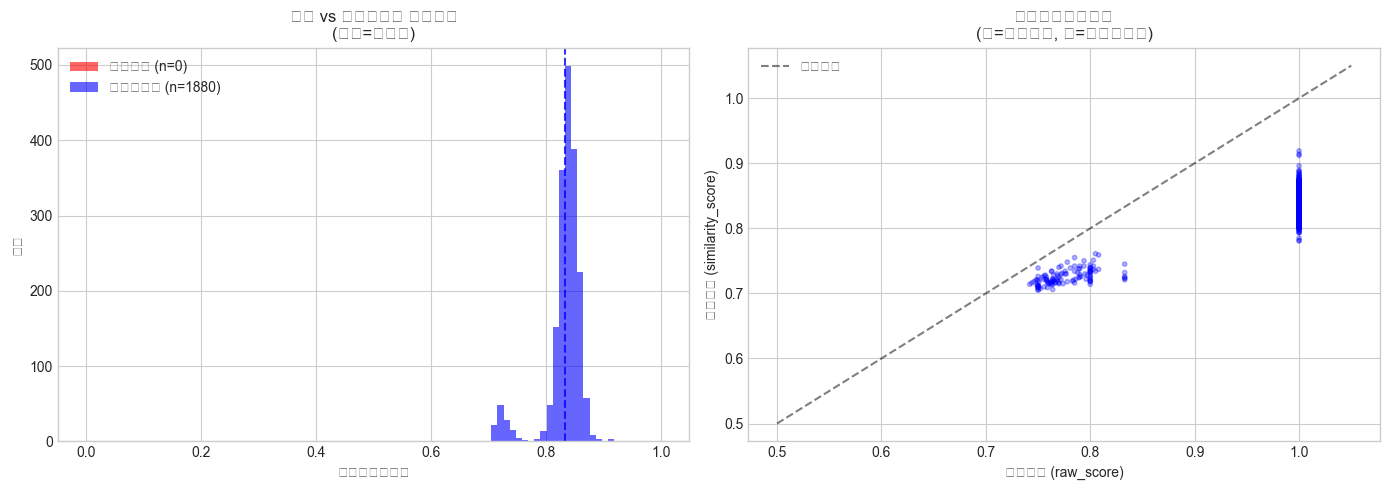


[图] 头部抑制效果:
  头部公司平均最终分数: nan
  非头部公司平均最终分数: 0.833
  差异: nan


In [23]:
# ==========================================
# 可视化：头部 vs 非头部公司的分数分布
# ==========================================

# 添加是否为头部公司的标记
df['is_head_company'] = df['recommended_id'].apply(
    lambda x: tags_dict.get(x, {}).get('company_stage', 'unknown') in ['public', 'bigtech_subsidiary', 'profitable', 'pre_ipo']
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：分数分布对比
ax1 = axes[0]
head_scores = df[df['is_head_company'] == True]['similarity_score']
nonhead_scores = df[df['is_head_company'] == False]['similarity_score']

ax1.hist(head_scores, bins=20, alpha=0.6, label=f'头部公司 (n={len(head_scores)})', color='red')
ax1.hist(nonhead_scores, bins=20, alpha=0.6, label=f'非头部公司 (n={len(nonhead_scores)})', color='blue')
ax1.axvline(head_scores.mean(), color='red', linestyle='--', alpha=0.8)
ax1.axvline(nonhead_scores.mean(), color='blue', linestyle='--', alpha=0.8)
ax1.set_xlabel('最终相似度分数')
ax1.set_ylabel('频次')
ax1.set_title('头部 vs 非头部公司 分数分布\n(虚线=平均值)')
ax1.legend()

# 右图：抑制前后分数对比
ax2 = axes[1]
ax2.scatter(df['raw_score'], df['similarity_score'], 
            c=df['is_head_company'].map({True: 'red', False: 'blue'}),
            alpha=0.3, s=10)
ax2.plot([0.5, 1.05], [0.5, 1.05], 'k--', alpha=0.5, label='无抑制线')
ax2.set_xlabel('原始分数 (raw_score)')
ax2.set_ylabel('最终分数 (similarity_score)')
ax2.set_title('抑制前后分数对比\n(红=头部公司, 蓝=非头部公司)')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\n[图] 头部抑制效果:")
print(f"  头部公司平均最终分数: {head_scores.mean():.3f}")
print(f"  非头部公司平均最终分数: {nonhead_scores.mean():.3f}")
print(f"  差异: {nonhead_scores.mean() - head_scores.mean():.3f}")

In [24]:
# ==========================================
# 头部公司详细分析
# 说明：看看具体哪些头部公司被推荐了多少次
# ==========================================

head_companies = recommended_counts[recommended_counts['stage'].isin(['public', 'bigtech_subsidiary', 'profitable', 'pre_ipo'])]

print("\n" + "="*60)
print("[大] 头部公司被推荐详情")
print("说明: 这些大公司应该被头部抑制策略有效控制")
print("="*60)
print(f"\n头部公司数: {len(head_companies)}")
print(f"头部公司总被推荐次数: {head_companies['times_recommended'].sum()}")
print(f"头部公司平均被推荐次数: {head_companies['times_recommended'].mean():.1f}")
print("\n* 头部公司被推荐排行：")
for _, row in head_companies.head(10).iterrows():
    print(f"  {row['company_name'][:25]:<25} | {row['times_recommended']:3d}次 | {row['stage']}")


[大] 头部公司被推荐详情
说明: 这些大公司应该被头部抑制策略有效控制

头部公司数: 0
头部公司总被推荐次数: 0
头部公司平均被推荐次数: nan

* 头部公司被推荐排行：


---
## 7. 总结与建议

In [25]:
# ==========================================
# 生成分析总结
# ==========================================

print("\n" + "="*80)
print("[表] 推荐系统效果分析总结")
print("="*80)

print("\n【1. 覆盖率与多样性】")
print(f"  • 推荐覆盖率: {coverage_rate:.1f}% (共{total_companies}家公司中有{unique_recommended}家被推荐)")
print(f"  • Top 10%公司占据 {top_10_pct_share:.1f}% 推荐位")
print(f"  • 互惠推荐率: {reciprocal_rate:.1f}%")

print("\n【2. 头部抑制效果】")
print(f"  • 抑制应用率: {penalty_rate:.1f}%")
print(f"  • 平均抑制幅度: {df_penalty['penalty_amount'].mean():.3f}")
print(f"  • 头部公司平均被推荐次数: {head_companies['times_recommended'].mean():.1f}")

print("\n【3. 分数质量】")
print(f"  • 平均最终分数: {df['similarity_score'].mean():.3f}")
print(f"  • 边缘推荐占比 (0.70-0.75): {len(edge_cases)/len(df)*100:.1f}%")

print("\n【4. 潜在问题】")
if len(never_recommended) > 10:
    print(f"  [!] {len(never_recommended)} 家公司从未被推荐，可能是推荐死角")
if top_10_pct_share > 50:
    print(f"  [!] 推荐过于集中，Top 10%公司占比超过50%")
if penalty_rate > 90:
    print(f"  [!] 头部抑制应用过于广泛 ({penalty_rate:.1f}%)，可能影响推荐质量")

print("\n" + "="*80)


[表] 推荐系统效果分析总结

【1. 覆盖率与多样性】
  • 推荐覆盖率: 64.4% (共132家公司中有85家被推荐)
  • Top 10%公司占据 27.2% 推荐位
  • 互惠推荐率: 37.8%

【2. 头部抑制效果】
  • 抑制应用率: 100.0%
  • 平均抑制幅度: 0.153
  • 头部公司平均被推荐次数: nan

【3. 分数质量】
  • 平均最终分数: 0.833
  • 边缘推荐占比 (0.70-0.75): 6.2%

【4. 潜在问题】
  [!] 47 家公司从未被推荐，可能是推荐死角
  [!] 头部抑制应用过于广泛 (100.0%)，可能影响推荐质量

